## RQ4

What is the most common way of payments? Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.

In [123]:
''' imports '''
import pandas as pd
import numpy as np
from loader import Loader
import matplotlib.pyplot as plt
%matplotlib notebook

''' data paths '''
data = {
    'jan': {
        'path': 'data/yellow_tripdata_2018-01.csv',
        'start': '2018-01-01',
        'end': '2018-01-31'
    },
    'feb': {
        'path': 'data/yellow_tripdata_2018-02.csv',
        'start': '2018-02-01',
        'end': '2018-02-28'
    },
    'mar': {
        'path': 'data/yellow_tripdata_2018-03.csv',
        'start': '2018-03-01',
        'end': '2018-03-31'
    },
    'apr': {
        'path': 'data/yellow_tripdata_2018-04.csv',
        'start': '2018-04-01',
        'end': '2018-04-30'
    },
    'may': {
        'path': 'data/yellow_tripdata_2018-05.csv',
        'start': '2018-05-01',
        'end': '2018-05-31'
    },
    'jun': {
        'path': 'data/yellow_tripdata_2018-06.csv',
        'start': '2018-06-01',
        'end': '2018-06-30'
    }
}
locations = 'data/taxi_zone_lookup.csv'

# that's a list made by month_name and file_path to be fed to Loader
MONTHS = [(m, data[m]['path']) for m in data.keys()]

Let's load all months datasets, reading all of them as they're concatenated and in chunks composed by 100000 lines per single batch. Finally, we get an iterator to access those data AIO.

**For more info about the Loader class, please, see the comments inside the 'loader.py'.**

In [125]:
# read data for each month
loader = Loader(csv=MONTHS, chunksize=100000)

# preparing locations to be merged on-the-fly when iterating
loader.merge(csv=locations, usecols=['LocationID', 'Borough'], on=('PULocationID', 'LocationID'), direction='left', drop_on_columns=True)

# get data generator
data_iterator = loader.iterate(usecols=['PULocationID', 'payment_type'])

This code below could seem messy but it is necessary (could be improved for sure, though) to gather data from chunks.

The basic flow could be understood from comments below. The gathered data will be organized per each month, boroughs and days.

In [126]:
''' working with each borough '''
# declaring two counters to enhance verbosity
tot_rows = 0
processed_rows = 0

# count will be stored here
# and incremented chunk by chunk
dg_bkp = None

# iterate over chunks
for month, d in data_iterator:
    
    # info
    tot_rows += len(d.index)
    
    # drop any row with missing values
    d = d.dropna()
    
    # group by and adding a count column
    dg = d.groupby(['payment_type', 'Borough']).Borough.agg('count').to_frame('count')
    
    # info
    processed_rows += len(d.index)
    
    # concat and save data
    dg_bkp = pd.concat([dg, dg_bkp]) if dg_bkp is not None else dg
    
    # re-group and sum() to keep less stuff in memory
    dg_bkp = dg_bkp.groupby(['payment_type', 'Borough']).sum()
    
print(str(processed_rows) + ' over ' + str(tot_rows) + ' rows have been processed')

53925735 over 53925735 rows have been processed


In [127]:
# defining payment methods as a DataFrame to be merged
methods = [('Credit Card', 1),
         ('Cash', 2),
         ('No chard', 3),
         ('Dispute', 4),
         ('Unknown', 5),
         ('Voided trip', 6)
        ]
labels = ['Method', 'code']

p = pd.DataFrame.from_records(methods, columns=labels)
p.head()

,Method,code
0,Credit Card,1
1,Cash,2
2,No chard,3
3,Dispute,4
4,Unknown,5


In [128]:
# expanding Borough index to each line
dg_bkp.reset_index(level=dg_bkp.index.names, inplace=True)

print(dg_bkp.head())

   payment_type    Borough     count
0             1      Bronx     27788
1             1   Brooklyn    441890
2             1        EWR      3036
3             1  Manhattan  34188788
4             1     Queens   2311245


In [129]:
# preparing data for plotting
dg_bkp_p = dg_bkp.merge(p, left_on='payment_type', right_on='code', how='left')

# fill NaN with zeros if any
dg_bkp_p = dg_bkp_p.fillna(0)
dg_bkp_p = dg_bkp_p.drop(['payment_type', 'code'], axis=1)

print(dg_bkp_p)

          Borough     count       Method
0           Bronx     27788  Credit Card
1        Brooklyn    441890  Credit Card
2             EWR      3036  Credit Card
3       Manhattan  34188788  Credit Card
4          Queens   2311245  Credit Card
5   Staten Island       434  Credit Card
6         Unknown    595317  Credit Card
7           Bronx     26147         Cash
8        Brooklyn    230533         Cash
9             EWR       551         Cash
10      Manhattan  14480638         Cash
11         Queens   1000704         Cash
12  Staten Island       318         Cash
13        Unknown    255817         Cash
14          Bronx      1515     No chard
15       Brooklyn      8789     No chard
16            EWR       220     No chard
17      Manhattan    226799     No chard
18         Queens     37296     No chard
19  Staten Island        50     No chard
20        Unknown     10652     No chard
21          Bronx       360      Dispute
22       Brooklyn      1923      Dispute
23            EW

<IPython.core.display.Javascript object>


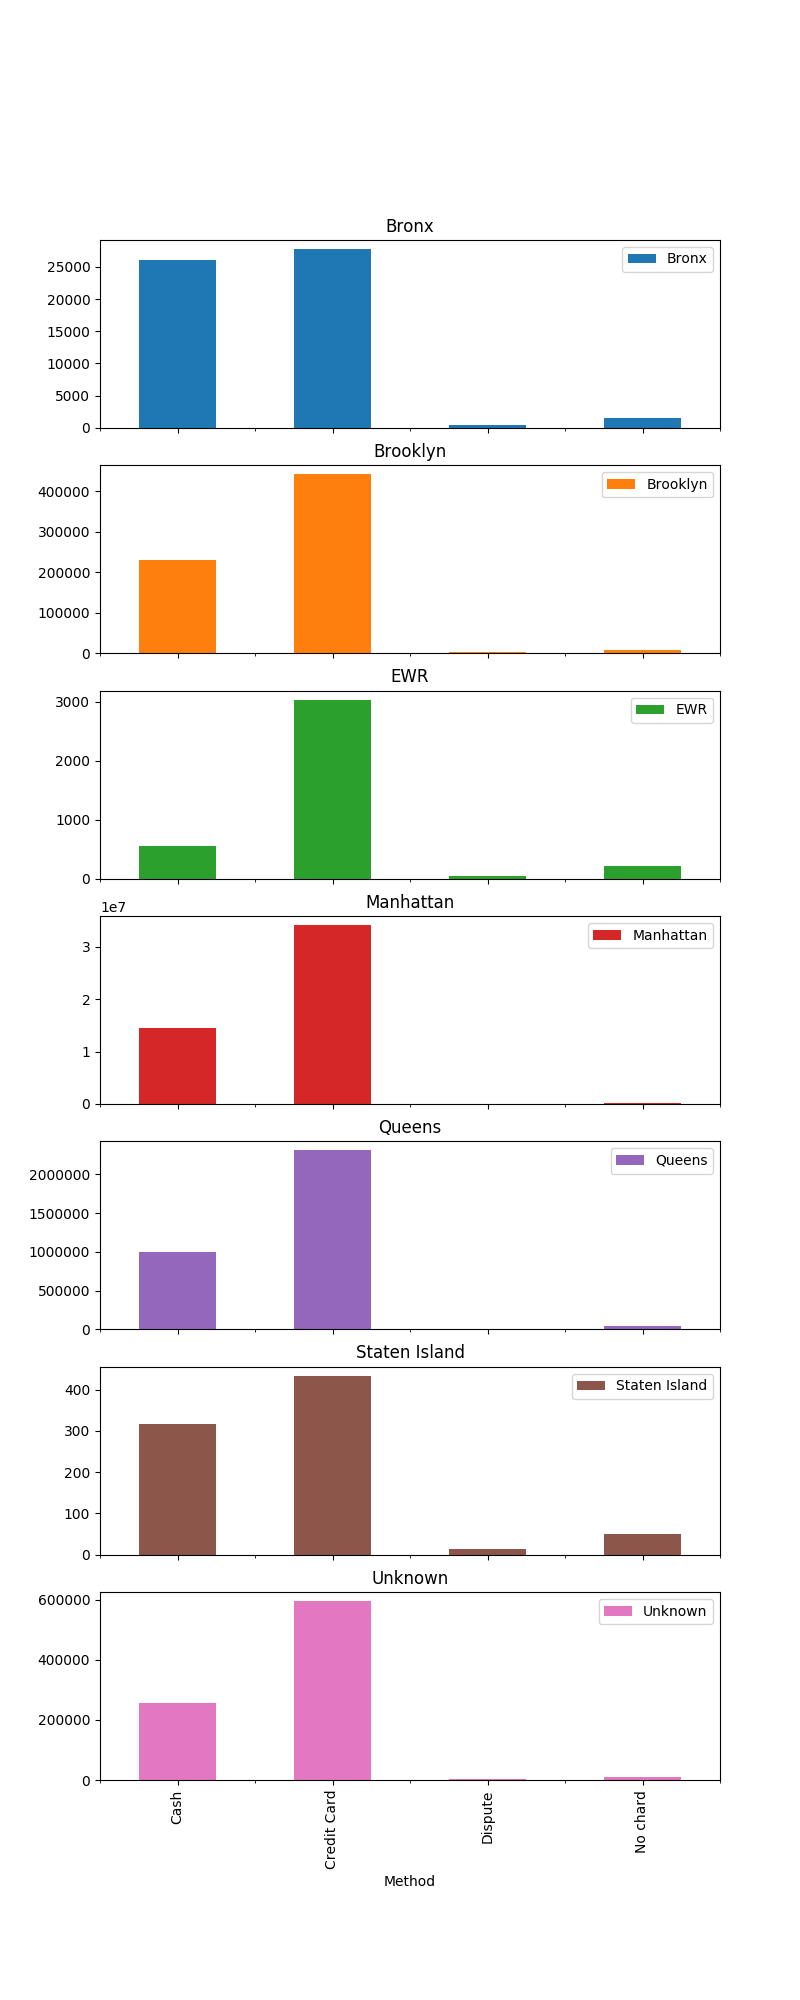

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff366de7c50>,
      dtype=object)

In [130]:
test = dg_bkp_p.groupby(['Method', 'Borough'])['count'].sum()
test.head()

test.unstack().plot(kind='bar', subplots=True, figsize=(8,20))

The plots above show the most commony payment methods for each borough. It is interesting that 5 out 1 (Bronx) follow the same trend where the credit card is preferred over others, whilst the Bronx still prefers cash payments a lot. It's noteworthy the amount of payments in Manhattan and Brooklyn in spite of the few other ones. Surprisingly (or not) the peak of *Disputes* and *No Card* were reached in Bronx and Staten Island.

Even in this case, it is noteworthy a modest percentage of noise caused by Unknown-labeled data.

**To better dive into plot data, just run this notebook to deal with an interactive zoomable plot**